In [1]:
import re
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
columns = [u'cm_key', u'mvar2', u'mvar3', u'mvar4', u'mvar5', u'mvar6', u'mvar7', u'mvar8', u'mvar9', u'mvar10',
           u'mvar11', u'mvar12', u'mvar13', u'mvar14', u'mvar15', u'mvar16', u'mvar17', u'mvar18', u'mvar19', u'mvar20',
           u'mvar21', u'mvar22', u'mvar23', u'mvar24', u'mvar25', u'mvar26', u'mvar27', u'mvar28', u'mvar29', u'mvar30',
           u'mvar31', u'mvar32', u'mvar33', u'mvar34', u'mvar35', u'mvar36', u'mvar37', u'mvar38', u'mvar39', u'mvar40',
           u'mvar41', u'mvar42', u'mvar43', u'mvar44', u'mvar45', u'income_by_spending', u'membership_by_n',
           u'avg_electronics', u'avg_travel', u'avg_household', u'avg_car', u'avg_retailer', u'months_by_card',
           u'avg_quater1', u'avg_quater2', u'avg_quater3', u'avg_quater4', 
           # u'accepted_by_extended_supp',u'accepted_by_extended_elite', u'accepted_by_extended_credit', 
           u'avg_total', u'avg_sectors_quaters',
           u'other_spend_quater1_by_total', u'other_spend_quater2_by_total', u'other_spend_quater3_by_total',
           u'other_spend_quater4_by_total', u'other_spend_by_total', u'membership_by_income',u'spending_by_income',
           u'income_by_family', u'spending_by_family', u'membership_by_family'

]
quantity_features = [
                    u'mvar3', u'mvar6', u'mvar9', u'mvar16', u'mvar17', u'mvar18', u'mvar19', u'mvar20',
                    u'mvar21', u'mvar22', u'mvar23', u'mvar24', u'mvar25', u'mvar26', u'mvar27', u'mvar28', u'mvar29', 
                    u'mvar30', u'mvar31', u'mvar32', u'mvar33', u'mvar34', u'mvar35', u'mvar36', u'mvar37', u'mvar38', 
                    u'mvar39', u'avg_electronics', u'avg_travel', u'avg_household', u'avg_car', u'avg_retailer',
                    u'avg_quater1', u'avg_quater2', u'avg_quater3', u'avg_quater4', u'avg_total', u'avg_sectors_quaters',
                    u'income_by_family', u'spending_by_family', u'membership_by_family'
]
ratio_features = [
                u'mvar7', u'mvar8', u'mvar11',
                u'other_spend_quater1_by_total', u'other_spend_quater2_by_total', u'other_spend_quater3_by_total',
                u'other_spend_quater4_by_total', u'other_spend_by_total', u'months_by_card', 
                # u'accepted_by_extended_supp', u'accepted_by_extended_elite', u'accepted_by_extended_credit', 
                u'income_by_spending', u'membership_by_n',u'membership_by_income',u'spending_by_income'
]
number_features = [
                 u'mvar13', u'mvar14', u'mvar15', u'mvar2', u'mvar4', u'mvar5', u'mvar40',
                 u'mvar41', u'mvar42', u'mvar43', u'mvar44', u'mvar45'
]

categorical_columns = [u'mvar12', u'mvar10']
labels = pd.Series(train.target.values)
train = train[columns]
test = test[columns]

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for feature in categorical_columns:
    train[feature] = le.fit_transform(train[feature])
    test[feature] = le.fit_transform(test[feature])
ltr = len(train)
test_key = test.cm_key
data = pd.concat([train, test], axis = 0)
data.drop(['cm_key'], axis = 1, inplace = True)
del train
del test

# Transform the skewed numeric features by taking log(feature + 1).
# This will make the features more normal.
# from scipy.stats import skew
# skewed = data[quantity_features].apply(lambda x: skew(x.dropna().astype(float)))
# skewed = skewed[skewed > 0.75]
# skewed = skewed.index
# data[skewed] = np.log1p(data[skewed])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data[quantity_features])
scaled = scaler.transform(data[quantity_features])
for i, col in enumerate(quantity_features):
    data[col] = scaled[:,i]

train_data_df = data[:ltr]
test_data_df = data[ltr:]

In [4]:
def printtofile(df, PROBABILITY_THRESHOLD):
    df.drop('0',1, inplace=True)
    filtr = lambda x: 1 if x > PROBABILITY_THRESHOLD else 0
    df['Credit'] = df['1'].apply(filtr)
    df['Elite'] = df['2'].apply(filtr)
    df['Supp'] = df['3'].apply(filtr)
    print df[['Credit', 'Elite', 'Supp']].values.sum()
    df['prob'] = df['1']*df['Credit'] + df['2']*df['Elite'] + df['3']*df['Supp']
    df['cm_key'] = range(50001, 50001+len(df))
    df.sort_values(['prob'], ascending=[False], inplace=True)
    df.drop(['1', '2', '3'],1, inplace=True)
    df['label_type'] = 6*df['Credit'] + 8*df['Elite'] + 10*df['Supp']
    lbl = lambda x: 'Credit' if x == 6 else ('Elite' if x == 8 else ('Supp' if x == 10 else 'Credit'))
    df['label'] = df['label_type'].apply(lbl)
    df.to_csv("final_results.csv", index=False)

In [5]:
import lightgbm as gbm
params = {
    'learning_rate': 0.01,
    'max_depth': 40,
    'min_child_weight': 15, 
    'min_child_samples': 15, 
    'objective': 'multiclass',
    'num_class':4,
    'tree_learner':'voting',
    'metric':'multi_logloss',
    'boosting_type': 'dart', 
    'nthread': 4,
    'min_split_gain': 0.75, 
    'scale_pos_weight': 1,
    'num_leaves': 20, 
    'feature_fraction': 0.4,
    'bagging_fraction': 0.5,
    'max_bin': 100, 
    'subsample': 0.6, 
    'colsample_bytree': 0.6, 
    'reg_alpha': 1, 
    'reg_lambda': 0.01
    }
gbm_tr = gbm.Dataset(train_data_df, label=labels)
INITIAL_MODEL = gbm.train(params, 
                gbm_tr, 
                num_boost_round=2000,
                evals_result=None,
                verbose_eval=True)

In [6]:
gbm_ts = gbm.Dataset(test_data_df)
y_pred=INITIAL_MODEL.predict(test_data_df)
submission = pd.DataFrame(y_pred, columns=['0','1','2','3'])
submission.to_csv("raw_results.csv")
printtofile(submission,0.275)

1008


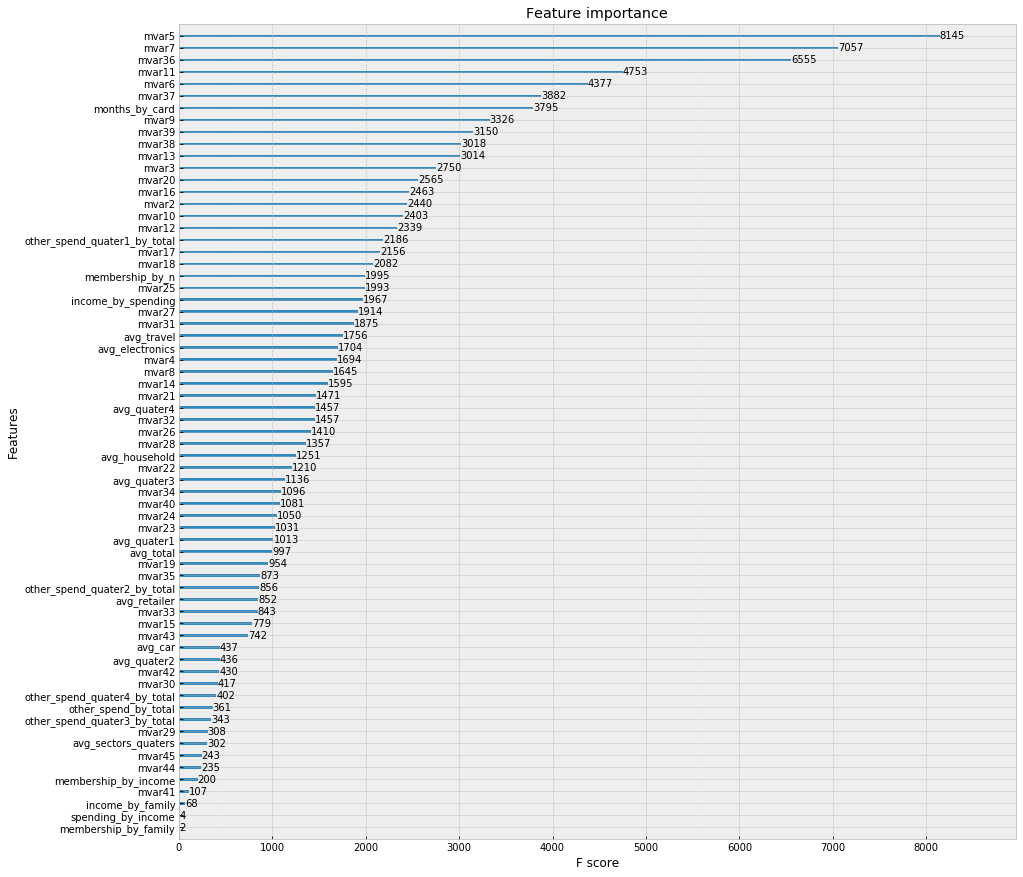

In [8]:
imp = gbm.plot_importance(INITIAL_MODEL, title='Feature importance', xlabel='F score', ylabel='Features')
figure = imp.figure
figure.set_size_inches(15, 15)
# This will tell us which features were most important in the series of trees.

In [70]:
cv_params = {
    'learning_rate': 0.01,
    'max_depth': 40,
    'min_child_weight': 15, 
    'min_child_samples': 15, 
    'objective': 'multiclass',
    'num_class':4,
    'tree_learner':'voting',
    'metric':'multi_logloss',
    'boosting_type': 'gbdt', 
    'nthread': 4,
    'min_split_gain': 0.75, 
    'scale_pos_weight': 1,
    'num_leaves': 20, 
    'feature_fraction': 0.4,
    'bagging_fraction': 0.5,
    'max_bin': 100, 
    'subsample': 0.6, 
    'colsample_bytree': 0.6, 
    'reg_alpha': 1, 
    'reg_lambda': 0.01
    }
gbm_tr = gbm.Dataset(train_data_df, label=labels)
# LightGBM, cross-validation
cvresult = gbm.cv(cv_params, 
                       gbm_tr, 
                       num_boost_round=2100, 
                       nfold=5, 
                       stratified=True, 
                       early_stopping_rounds=50, 
                       verbose_eval=1)
print('best n_estimators:', len(cvresult['multi_logloss-mean']))
print('best cv score:', cvresult['multi_logloss-mean'][-1])

[1]	cv_agg's multi_logloss: 1.37593 + 1.61963e-05
[2]	cv_agg's multi_logloss: 1.36577 + 4.04553e-05
[3]	cv_agg's multi_logloss: 1.35576 + 5.95947e-05
[4]	cv_agg's multi_logloss: 1.34604 + 7.95209e-05
[5]	cv_agg's multi_logloss: 1.33643 + 9.48126e-05
[6]	cv_agg's multi_logloss: 1.32702 + 0.000113248
[7]	cv_agg's multi_logloss: 1.31777 + 0.000127105
[8]	cv_agg's multi_logloss: 1.30868 + 0.00013492
[9]	cv_agg's multi_logloss: 1.29974 + 0.000143953
[10]	cv_agg's multi_logloss: 1.291 + 0.000152306
[11]	cv_agg's multi_logloss: 1.2824 + 0.000162329
[12]	cv_agg's multi_logloss: 1.27404 + 0.000176492
[13]	cv_agg's multi_logloss: 1.26578 + 0.000188726
[14]	cv_agg's multi_logloss: 1.25766 + 0.000198616
[15]	cv_agg's multi_logloss: 1.2496 + 0.000208907
[16]	cv_agg's multi_logloss: 1.24168 + 0.00021664
[17]	cv_agg's multi_logloss: 1.23392 + 0.000230981
[18]	cv_agg's multi_logloss: 1.22633 + 0.000237203
[19]	cv_agg's multi_logloss: 1.21883 + 0.000243733
[20]	cv_agg's multi_logloss: 1.21143 + 0.00025

[160]	cv_agg's multi_logloss: 0.774388 + 0.00124128
[161]	cv_agg's multi_logloss: 0.773339 + 0.00124724
[162]	cv_agg's multi_logloss: 0.772207 + 0.00124884
[163]	cv_agg's multi_logloss: 0.771185 + 0.0012604
[164]	cv_agg's multi_logloss: 0.770173 + 0.00126074
[165]	cv_agg's multi_logloss: 0.769161 + 0.00126783
[166]	cv_agg's multi_logloss: 0.768093 + 0.00127522
[167]	cv_agg's multi_logloss: 0.767043 + 0.0012783
[168]	cv_agg's multi_logloss: 0.766037 + 0.00128321
[169]	cv_agg's multi_logloss: 0.764989 + 0.00128932
[170]	cv_agg's multi_logloss: 0.76402 + 0.00129437
[171]	cv_agg's multi_logloss: 0.763095 + 0.00130379
[172]	cv_agg's multi_logloss: 0.762138 + 0.00131148
[173]	cv_agg's multi_logloss: 0.761221 + 0.00132151
[174]	cv_agg's multi_logloss: 0.760327 + 0.00132695
[175]	cv_agg's multi_logloss: 0.759404 + 0.00133327
[176]	cv_agg's multi_logloss: 0.758432 + 0.00134394
[177]	cv_agg's multi_logloss: 0.757492 + 0.00135106
[178]	cv_agg's multi_logloss: 0.756634 + 0.00135862
[179]	cv_agg's 

[319]	cv_agg's multi_logloss: 0.692198 + 0.00206896
[320]	cv_agg's multi_logloss: 0.691936 + 0.00207491
[321]	cv_agg's multi_logloss: 0.691761 + 0.00207766
[322]	cv_agg's multi_logloss: 0.691541 + 0.00208821
[323]	cv_agg's multi_logloss: 0.691317 + 0.00209141
[324]	cv_agg's multi_logloss: 0.691106 + 0.00209374
[325]	cv_agg's multi_logloss: 0.690909 + 0.00210266
[326]	cv_agg's multi_logloss: 0.690665 + 0.0021053
[327]	cv_agg's multi_logloss: 0.690447 + 0.00210669
[328]	cv_agg's multi_logloss: 0.690287 + 0.00210699
[329]	cv_agg's multi_logloss: 0.690143 + 0.00211157
[330]	cv_agg's multi_logloss: 0.689902 + 0.00211653
[331]	cv_agg's multi_logloss: 0.689689 + 0.00212043
[332]	cv_agg's multi_logloss: 0.689531 + 0.00212894
[333]	cv_agg's multi_logloss: 0.689395 + 0.00213501
[334]	cv_agg's multi_logloss: 0.68924 + 0.00213475
[335]	cv_agg's multi_logloss: 0.689085 + 0.00213786
[336]	cv_agg's multi_logloss: 0.688878 + 0.00214017
[337]	cv_agg's multi_logloss: 0.688688 + 0.00213886
[338]	cv_agg's

[478]	cv_agg's multi_logloss: 0.67128 + 0.00273774
[479]	cv_agg's multi_logloss: 0.671164 + 0.00273582
[480]	cv_agg's multi_logloss: 0.671054 + 0.00273754
[481]	cv_agg's multi_logloss: 0.671003 + 0.0027401
[482]	cv_agg's multi_logloss: 0.670889 + 0.00274335
[483]	cv_agg's multi_logloss: 0.670839 + 0.00274476
[484]	cv_agg's multi_logloss: 0.670773 + 0.00274492
[485]	cv_agg's multi_logloss: 0.670663 + 0.00274892
[486]	cv_agg's multi_logloss: 0.670524 + 0.00275399
[487]	cv_agg's multi_logloss: 0.670429 + 0.00276264
[488]	cv_agg's multi_logloss: 0.670336 + 0.00276524
[489]	cv_agg's multi_logloss: 0.670228 + 0.00275776
[490]	cv_agg's multi_logloss: 0.670136 + 0.00275321
[491]	cv_agg's multi_logloss: 0.670018 + 0.00276154
[492]	cv_agg's multi_logloss: 0.669963 + 0.00276176
[493]	cv_agg's multi_logloss: 0.669907 + 0.00276498
[494]	cv_agg's multi_logloss: 0.669857 + 0.00276444
[495]	cv_agg's multi_logloss: 0.66974 + 0.00276398
[496]	cv_agg's multi_logloss: 0.669691 + 0.00276358
[497]	cv_agg's 

[637]	cv_agg's multi_logloss: 0.660978 + 0.00293139
[638]	cv_agg's multi_logloss: 0.660906 + 0.0029326
[639]	cv_agg's multi_logloss: 0.660876 + 0.0029273
[640]	cv_agg's multi_logloss: 0.66085 + 0.00293005
[641]	cv_agg's multi_logloss: 0.660802 + 0.00293395
[642]	cv_agg's multi_logloss: 0.660778 + 0.00293151
[643]	cv_agg's multi_logloss: 0.660738 + 0.0029283
[644]	cv_agg's multi_logloss: 0.660679 + 0.00292846
[645]	cv_agg's multi_logloss: 0.660613 + 0.00292896
[646]	cv_agg's multi_logloss: 0.660554 + 0.00292836
[647]	cv_agg's multi_logloss: 0.660523 + 0.00292568
[648]	cv_agg's multi_logloss: 0.660483 + 0.00292912
[649]	cv_agg's multi_logloss: 0.660431 + 0.00292852
[650]	cv_agg's multi_logloss: 0.660384 + 0.00292789
[651]	cv_agg's multi_logloss: 0.660351 + 0.00292807
[652]	cv_agg's multi_logloss: 0.660308 + 0.00292688
[653]	cv_agg's multi_logloss: 0.660242 + 0.00293061
[654]	cv_agg's multi_logloss: 0.660174 + 0.0029264
[655]	cv_agg's multi_logloss: 0.660156 + 0.00292532
[656]	cv_agg's mu

[796]	cv_agg's multi_logloss: 0.655162 + 0.0030644
[797]	cv_agg's multi_logloss: 0.655142 + 0.00306299
[798]	cv_agg's multi_logloss: 0.655127 + 0.0030632
[799]	cv_agg's multi_logloss: 0.655108 + 0.00306118
[800]	cv_agg's multi_logloss: 0.655091 + 0.00306175
[801]	cv_agg's multi_logloss: 0.655079 + 0.00306317
[802]	cv_agg's multi_logloss: 0.655045 + 0.00306485
[803]	cv_agg's multi_logloss: 0.655022 + 0.00306228
[804]	cv_agg's multi_logloss: 0.654998 + 0.00306174
[805]	cv_agg's multi_logloss: 0.654971 + 0.0030584
[806]	cv_agg's multi_logloss: 0.654934 + 0.00306304
[807]	cv_agg's multi_logloss: 0.65489 + 0.00306059
[808]	cv_agg's multi_logloss: 0.654871 + 0.0030653
[809]	cv_agg's multi_logloss: 0.654849 + 0.0030654
[810]	cv_agg's multi_logloss: 0.654828 + 0.00306678
[811]	cv_agg's multi_logloss: 0.654808 + 0.00306473
[812]	cv_agg's multi_logloss: 0.654754 + 0.00306746
[813]	cv_agg's multi_logloss: 0.65472 + 0.00307736
[814]	cv_agg's multi_logloss: 0.654673 + 0.0030831
[815]	cv_agg's multi

[955]	cv_agg's multi_logloss: 0.651483 + 0.00317274
[956]	cv_agg's multi_logloss: 0.651473 + 0.00317455
[957]	cv_agg's multi_logloss: 0.651452 + 0.00317311
[958]	cv_agg's multi_logloss: 0.651422 + 0.00317564
[959]	cv_agg's multi_logloss: 0.651401 + 0.00317182
[960]	cv_agg's multi_logloss: 0.651382 + 0.00317422
[961]	cv_agg's multi_logloss: 0.65137 + 0.00317525
[962]	cv_agg's multi_logloss: 0.651354 + 0.00317923
[963]	cv_agg's multi_logloss: 0.651343 + 0.00318103
[964]	cv_agg's multi_logloss: 0.65134 + 0.00318271
[965]	cv_agg's multi_logloss: 0.651313 + 0.00318447
[966]	cv_agg's multi_logloss: 0.651293 + 0.00318119
[967]	cv_agg's multi_logloss: 0.651286 + 0.003182
[968]	cv_agg's multi_logloss: 0.651279 + 0.00318297
[969]	cv_agg's multi_logloss: 0.651263 + 0.0031846
[970]	cv_agg's multi_logloss: 0.651237 + 0.00318339
[971]	cv_agg's multi_logloss: 0.651225 + 0.00318281
[972]	cv_agg's multi_logloss: 0.651217 + 0.00318385
[973]	cv_agg's multi_logloss: 0.651212 + 0.00318187
[974]	cv_agg's mu

[1112]	cv_agg's multi_logloss: 0.649358 + 0.00326822
[1113]	cv_agg's multi_logloss: 0.649346 + 0.00327175
[1114]	cv_agg's multi_logloss: 0.649339 + 0.00327206
[1115]	cv_agg's multi_logloss: 0.649324 + 0.00327488
[1116]	cv_agg's multi_logloss: 0.649309 + 0.00327492
[1117]	cv_agg's multi_logloss: 0.64929 + 0.00327268
[1118]	cv_agg's multi_logloss: 0.649276 + 0.00327859
[1119]	cv_agg's multi_logloss: 0.649263 + 0.00328053
[1120]	cv_agg's multi_logloss: 0.649258 + 0.00327976
[1121]	cv_agg's multi_logloss: 0.649246 + 0.00327682
[1122]	cv_agg's multi_logloss: 0.649241 + 0.00327959
[1123]	cv_agg's multi_logloss: 0.649234 + 0.00327756
[1124]	cv_agg's multi_logloss: 0.64923 + 0.00327501
[1125]	cv_agg's multi_logloss: 0.649212 + 0.00327693
[1126]	cv_agg's multi_logloss: 0.649198 + 0.00327438
[1127]	cv_agg's multi_logloss: 0.649194 + 0.0032778
[1128]	cv_agg's multi_logloss: 0.649181 + 0.00327639
[1129]	cv_agg's multi_logloss: 0.649176 + 0.00327783
[1130]	cv_agg's multi_logloss: 0.649164 + 0.00327

[1269]	cv_agg's multi_logloss: 0.647867 + 0.0033431
[1270]	cv_agg's multi_logloss: 0.64786 + 0.00334398
[1271]	cv_agg's multi_logloss: 0.647847 + 0.00334527
[1272]	cv_agg's multi_logloss: 0.647835 + 0.00334655
[1273]	cv_agg's multi_logloss: 0.64783 + 0.00334882
[1274]	cv_agg's multi_logloss: 0.647827 + 0.00334835
[1275]	cv_agg's multi_logloss: 0.647825 + 0.00334944
[1276]	cv_agg's multi_logloss: 0.647814 + 0.00334743
[1277]	cv_agg's multi_logloss: 0.647802 + 0.00334779
[1278]	cv_agg's multi_logloss: 0.647794 + 0.00334976
[1279]	cv_agg's multi_logloss: 0.647788 + 0.00335024
[1280]	cv_agg's multi_logloss: 0.647776 + 0.00335041
[1281]	cv_agg's multi_logloss: 0.647764 + 0.00334917
[1282]	cv_agg's multi_logloss: 0.647758 + 0.00334565
[1283]	cv_agg's multi_logloss: 0.647756 + 0.00334675
[1284]	cv_agg's multi_logloss: 0.647745 + 0.00334798
[1285]	cv_agg's multi_logloss: 0.647739 + 0.0033469
[1286]	cv_agg's multi_logloss: 0.647727 + 0.00334757
[1287]	cv_agg's multi_logloss: 0.647725 + 0.003346

[1425]	cv_agg's multi_logloss: 0.646949 + 0.00339494
[1426]	cv_agg's multi_logloss: 0.646945 + 0.00339499
[1427]	cv_agg's multi_logloss: 0.646946 + 0.00339664
[1428]	cv_agg's multi_logloss: 0.64694 + 0.00339795
[1429]	cv_agg's multi_logloss: 0.646938 + 0.00339669
[1430]	cv_agg's multi_logloss: 0.646935 + 0.00339909
[1431]	cv_agg's multi_logloss: 0.646929 + 0.00339942
[1432]	cv_agg's multi_logloss: 0.646929 + 0.00339986
[1433]	cv_agg's multi_logloss: 0.646927 + 0.00340194
[1434]	cv_agg's multi_logloss: 0.646922 + 0.00340155
[1435]	cv_agg's multi_logloss: 0.646915 + 0.00340278
[1436]	cv_agg's multi_logloss: 0.646911 + 0.00340646
[1437]	cv_agg's multi_logloss: 0.646907 + 0.00340591
[1438]	cv_agg's multi_logloss: 0.646902 + 0.00340397
[1439]	cv_agg's multi_logloss: 0.646896 + 0.00340386
[1440]	cv_agg's multi_logloss: 0.64689 + 0.00340383
[1441]	cv_agg's multi_logloss: 0.646886 + 0.00340406
[1442]	cv_agg's multi_logloss: 0.646882 + 0.00340369
[1443]	cv_agg's multi_logloss: 0.646868 + 0.0034

[1582]	cv_agg's multi_logloss: 0.64628 + 0.00348712
[1583]	cv_agg's multi_logloss: 0.646278 + 0.00348737
[1584]	cv_agg's multi_logloss: 0.646274 + 0.00348834
[1585]	cv_agg's multi_logloss: 0.64627 + 0.00348938
[1586]	cv_agg's multi_logloss: 0.646263 + 0.00349264
[1587]	cv_agg's multi_logloss: 0.646257 + 0.0034947
[1588]	cv_agg's multi_logloss: 0.646253 + 0.00349392
[1589]	cv_agg's multi_logloss: 0.646252 + 0.00349274
[1590]	cv_agg's multi_logloss: 0.646246 + 0.00349441
[1591]	cv_agg's multi_logloss: 0.646242 + 0.00349522
[1592]	cv_agg's multi_logloss: 0.646242 + 0.00349483
[1593]	cv_agg's multi_logloss: 0.646238 + 0.00349581
[1594]	cv_agg's multi_logloss: 0.64623 + 0.00349294
[1595]	cv_agg's multi_logloss: 0.646229 + 0.00348948
[1596]	cv_agg's multi_logloss: 0.646226 + 0.00349144
[1597]	cv_agg's multi_logloss: 0.64622 + 0.00349236
[1598]	cv_agg's multi_logloss: 0.646217 + 0.00349304
[1599]	cv_agg's multi_logloss: 0.646213 + 0.003493
[1600]	cv_agg's multi_logloss: 0.646208 + 0.00349129


[1738]	cv_agg's multi_logloss: 0.645816 + 0.00351793
[1739]	cv_agg's multi_logloss: 0.645814 + 0.00351784
[1740]	cv_agg's multi_logloss: 0.645812 + 0.00351754
[1741]	cv_agg's multi_logloss: 0.64581 + 0.00351762
[1742]	cv_agg's multi_logloss: 0.64581 + 0.00351813
[1743]	cv_agg's multi_logloss: 0.645808 + 0.00351865
[1744]	cv_agg's multi_logloss: 0.645802 + 0.00351901
[1745]	cv_agg's multi_logloss: 0.645802 + 0.00351843
[1746]	cv_agg's multi_logloss: 0.645802 + 0.00351941
[1747]	cv_agg's multi_logloss: 0.645801 + 0.00351946
[1748]	cv_agg's multi_logloss: 0.6458 + 0.00352005
[1749]	cv_agg's multi_logloss: 0.645798 + 0.00352035
[1750]	cv_agg's multi_logloss: 0.645797 + 0.00352056
[1751]	cv_agg's multi_logloss: 0.645795 + 0.00352149
[1752]	cv_agg's multi_logloss: 0.645789 + 0.00352099
[1753]	cv_agg's multi_logloss: 0.645788 + 0.00352052
[1754]	cv_agg's multi_logloss: 0.645782 + 0.00352013
[1755]	cv_agg's multi_logloss: 0.645782 + 0.00352012
[1756]	cv_agg's multi_logloss: 0.645781 + 0.003516

[1895]	cv_agg's multi_logloss: 0.645588 + 0.00354532
[1896]	cv_agg's multi_logloss: 0.645586 + 0.00354524
[1897]	cv_agg's multi_logloss: 0.645582 + 0.00354564
[1898]	cv_agg's multi_logloss: 0.645582 + 0.00354553
[1899]	cv_agg's multi_logloss: 0.645582 + 0.00354594
[1900]	cv_agg's multi_logloss: 0.645578 + 0.00354662
[1901]	cv_agg's multi_logloss: 0.645577 + 0.00354657
[1902]	cv_agg's multi_logloss: 0.645577 + 0.00354659
[1903]	cv_agg's multi_logloss: 0.645577 + 0.00354659
[1904]	cv_agg's multi_logloss: 0.645577 + 0.00354659
[1905]	cv_agg's multi_logloss: 0.645577 + 0.00354659
[1906]	cv_agg's multi_logloss: 0.645577 + 0.00354662
[1907]	cv_agg's multi_logloss: 0.645577 + 0.00354662
[1908]	cv_agg's multi_logloss: 0.645577 + 0.00354657
[1909]	cv_agg's multi_logloss: 0.645577 + 0.00354657
[1910]	cv_agg's multi_logloss: 0.645576 + 0.0035465
[1911]	cv_agg's multi_logloss: 0.645576 + 0.00354668
[1912]	cv_agg's multi_logloss: 0.645573 + 0.00354668
[1913]	cv_agg's multi_logloss: 0.645572 + 0.003

[2052]	cv_agg's multi_logloss: 0.645482 + 0.0035368
[2053]	cv_agg's multi_logloss: 0.645482 + 0.00353674
[2054]	cv_agg's multi_logloss: 0.645482 + 0.00353683
[2055]	cv_agg's multi_logloss: 0.645482 + 0.00353685
[2056]	cv_agg's multi_logloss: 0.645481 + 0.00353678
[2057]	cv_agg's multi_logloss: 0.645481 + 0.00353671
[2058]	cv_agg's multi_logloss: 0.645481 + 0.00353671
[2059]	cv_agg's multi_logloss: 0.645481 + 0.00353689
[2060]	cv_agg's multi_logloss: 0.645481 + 0.00353689
[2061]	cv_agg's multi_logloss: 0.645481 + 0.0035368
[2062]	cv_agg's multi_logloss: 0.645481 + 0.00353634
[2063]	cv_agg's multi_logloss: 0.645481 + 0.00353633
[2064]	cv_agg's multi_logloss: 0.64548 + 0.00353626
[2065]	cv_agg's multi_logloss: 0.64548 + 0.00353607
[2066]	cv_agg's multi_logloss: 0.64548 + 0.00353575
[2067]	cv_agg's multi_logloss: 0.645479 + 0.0035356
[2068]	cv_agg's multi_logloss: 0.645474 + 0.00353596
[2069]	cv_agg's multi_logloss: 0.645473 + 0.00353622
[2070]	cv_agg's multi_logloss: 0.645473 + 0.00353593